In [125]:
import torchvision
import torch
import numpy as np
from torch.utils.data import Subset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math
plt.rcParams['image.cmap'] = 'gray'

In [126]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=0, std=1)
])
dataset = torchvision.datasets.MNIST(root='data', transform=transforms)
data_five = Subset(dataset, np.where(dataset.targets == 5)[0])

dataloader = DataLoader(data_five, batch_size=16, shuffle=True)

In [127]:
len(data_five)

5421

In [128]:
torch.min(data_five[0][0]), torch.max(data_five[0][0]), data_five[0][0].shape

(tensor(0.), tensor(1.), torch.Size([1, 28, 28]))

In [129]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

In [130]:
class GanComponent(torch.nn.Module):
    def __init__(self):
        super(GanComponent, self).__init__()

    def lock(self):
        for param in self.parameters():
            param.requires_grad = False

    def unlock(self):
        for param in self.parameters():
            param.requires_grad = True

In [131]:
class Generator(GanComponent):
    def __init__(self, input_length, output_image_size):
        super(Generator, self).__init__()
        self.input = torch.nn.Linear(input_length, 512)
        self.activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(p=.3)
        self.h1 = torch.nn.Linear(self.input.out_features, self.input.out_features*2)
        self.h2 = torch.nn.Linear(self.h1.out_features, self.h1.out_features*2)
        self.output = torch.nn.Linear(self.h2.out_features, output_image_size[1] * output_image_size[2])
        self.sigmoid = torch.nn.Tanh()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

In [132]:
class Discriminator(GanComponent):
    def __init__(self, input_image_size):
        super(Discriminator, self).__init__()

        self.input = torch.nn.Linear(input_image_size[1] * input_image_size[2], 1024)
        self.activation = torch.nn.LeakyReLU()
        self.dropout = torch.nn.Dropout(p=.3)
        self.h1 = torch.nn.Linear(self.input.out_features, self.input.out_features // 2)
        self.h2 = torch.nn.Linear(self.h1.out_features, self.h1.out_features // 2)
        self.output = torch.nn.Linear(self.h2.out_features, 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.input(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h1(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.h2(x)
        x = self.activation(x)
        x = self.dropout(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

<h3> Training </h3>

In [133]:
image_shape = data_five[0][0].shape
noise_vector_length = 500
gen = Generator(noise_vector_length, data_five[0][0].shape)
gen.apply(weights_init)
discr = Discriminator(data_five[0][0].shape)
discr.apply(weights_init)

n_iterations = 10
k = 1

gen_optimizer = torch.optim.Adam(gen.parameters(), lr=.0001)
discr_optimizer = torch.optim.Adam(discr.parameters(), lr=.0001, maximize=True)

for i in tqdm(range(n_iterations)):
    for batch, _ in dataloader:
        # discr.unlock()
        # gen.lock()

        running_discr_loss = 0.0
        for _ in range(k):
            noise_batch = torch.normal(0, 1, size=(batch.shape[0], noise_vector_length))
            # noise_batch = torch.rand((batch.shape[0], noise_vector_length))

            discr_real_output = discr(batch.flatten(start_dim=1))
            discr_fake_output = discr(gen(noise_batch))
            discr_loss = ((torch.log(discr_real_output) + torch.log(1-discr_fake_output))).mean()
            running_discr_loss += discr_loss.item()
            discr_optimizer.zero_grad()
            discr_loss.backward()
            discr_optimizer.step()

        # discr.lock()
        # gen.unlock()
        noise_batch = torch.rand((batch.shape[0], noise_vector_length))

        gen_loss = torch.log(1-discr(gen(noise_batch))).mean()
        gen_optimizer.zero_grad()
        gen_loss.backward()
        gen_optimizer.step()

        if math.isnan(running_discr_loss/k):
            print("")
        print(f"Discriminiator loss: {running_discr_loss/k}, Generator loss: {gen_loss.item()}")

  0%|          | 0/10 [00:00<?, ?it/s]

Discriminiator loss: -1.3875408172607422, Generator loss: -0.6680315732955933
Discriminiator loss: -1.3858367204666138, Generator loss: -0.669259250164032
Discriminiator loss: -1.380373477935791, Generator loss: -0.6705548167228699
Discriminiator loss: -1.3781085014343262, Generator loss: -0.672379732131958
Discriminiator loss: -1.3733938932418823, Generator loss: -0.6735568046569824
Discriminiator loss: -1.371839165687561, Generator loss: -0.6733831167221069
Discriminiator loss: -1.364495873451233, Generator loss: -0.6764001250267029
Discriminiator loss: -1.370452880859375, Generator loss: -0.6763247847557068
Discriminiator loss: -1.361342430114746, Generator loss: -0.678534746170044
Discriminiator loss: -1.3613193035125732, Generator loss: -0.6810556650161743
Discriminiator loss: -1.3499380350112915, Generator loss: -0.6807753443717957
Discriminiator loss: -1.3532228469848633, Generator loss: -0.6845780611038208
Discriminiator loss: -1.3496143817901611, Generator loss: -0.69091421365

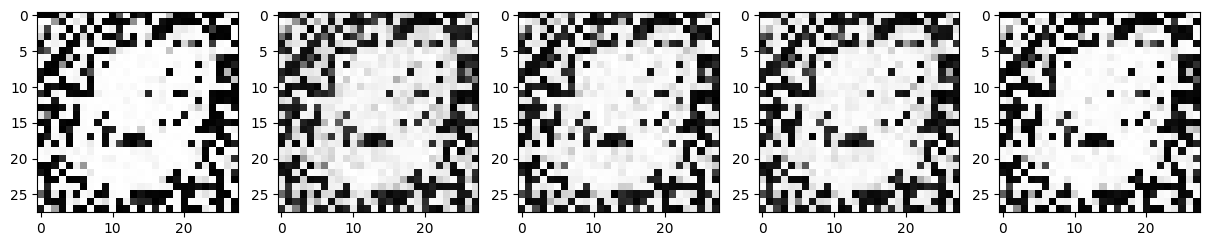

In [134]:
figs, axs = plt.subplots(1, 5, figsize=(15, 15))
# noise_sample = torch.rand((5, noise_vector_length))
noise_sample = torch.normal(0, 1, size=(5, noise_vector_length))

output = gen(noise_sample)
output_shape = dataset[0][0].shape
for i in range(5):
    reshaped = torch.reshape(output[i], output_shape)
    axs[i].imshow(reshaped.detach().numpy()[0])

In [135]:
noise_batch = torch.rand((1, noise_vector_length))

In [136]:
torch.min(noise_batch), torch.max(noise_batch)

(tensor(0.0055), tensor(0.9958))